# VeloViz with Unwounded Ker IFE cells
Marissa Esteban
1/12/2026
 

In [1]:
# Setup
import scanpy as sc
import scvelo as scv
import anndata
import loompy
import mygene
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from VelocityObject import VelocityObject
import pandas as pd
import scipy.sparse as sp
import numpy as np
from scipy.io import mmwrite

In [11]:
import numpy as np
import scipy.sparse as sp
import scvelo as scv
import pandas as pd

def _flat_data(X):
    """Return 1D array of stored values (sparse: data only; dense: ravel)."""
    if sp.issparse(X):
        return X.data
    return np.asarray(X).ravel()

def layer_value_stats(adata, layer="velocity", eps=1e-12):
    """Entry-wise stats for a layer: finite/nan/inf/zero/neg counts & fractions."""
    X = adata.layers[layer]
    d = _flat_data(X)

    n = d.size
    finite = np.isfinite(d)
    nan = np.isnan(d)
    inf = np.isinf(d)

    # Note: for sparse matrices, implicit zeros are NOT in X.data
    # so "zero count" here is among stored values only.
    zeros = (d == 0) & finite
    neg = (d < 0) & finite
    pos = (d > 0) & finite

    out = {
        "layer": layer,
        "stored_n": int(n),
        "finite_n": int(finite.sum()),
        "nan_n": int(nan.sum()),
        "inf_n": int(inf.sum()),
        "zero_n(stored)": int(zeros.sum()),
        "neg_n(stored)": int(neg.sum()),
        "pos_n(stored)": int(pos.sum()),
        "finite_frac": float(finite.mean()) if n else np.nan,
        "nan_frac": float(nan.mean()) if n else np.nan,
        "inf_frac": float(inf.mean()) if n else np.nan,
        "zero_frac(stored, finite)": float(zeros.sum() / max(finite.sum(), 1)),
        "neg_frac(stored, finite)": float(neg.sum() / max(finite.sum(), 1)),
        "pos_frac(stored, finite)": float(pos.sum() / max(finite.sum(), 1)),
    }
    return out

def cell_velocity_norm_stats(adata, layer="velocity", eps=1e-12, assume_cells_by_genes=True):
    """
    Cell-wise velocity magnitude stats.
    If your velocity layer is cells x genes (typical for AnnData), assume_cells_by_genes=True.
    """
    V = adata.layers[layer]

    if sp.issparse(V):
        # compute L2 norm per row (cell) efficiently
        if assume_cells_by_genes:
            row_sq_sum = np.array(V.multiply(V).sum(axis=1)).ravel()
            norms = np.sqrt(row_sq_sum)
        else:
            col_sq_sum = np.array(V.multiply(V).sum(axis=0)).ravel()
            norms = np.sqrt(col_sq_sum)
    else:
        Vd = np.asarray(V)
        norms = np.linalg.norm(Vd, axis=1 if assume_cells_by_genes else 0)

    zero = norms == 0
    near_zero = norms < eps
    out = {
        "cells_n": int(norms.size),
        "zero_vel_cells_n": int(zero.sum()),
        "zero_vel_cells_frac": float(zero.mean()),
        "near_zero_vel_cells_n": int(near_zero.sum()),
        "near_zero_vel_cells_frac": float(near_zero.mean()),
        "vel_norm_median": float(np.median(norms)),
        "vel_norm_mean": float(np.mean(norms)),
        "vel_norm_p95": float(np.quantile(norms, 0.95)),
        "vel_norm_max": float(np.max(norms)),
    }
    return out

def report_velocity(adata, label, eps=1e-12):
    """Combine entry-wise + cell-wise stats into a compact report dict."""
    entry = layer_value_stats(adata, layer="velocity", eps=eps)
    cell  = cell_velocity_norm_stats(adata, layer="velocity", eps=eps, assume_cells_by_genes=True)
    return {"mode": label, **entry, **cell}


In [2]:
h5ad_path = "/Volumes/PortableSSD/SRSP/CITEseq_Keratinocytes/UW_IFE.h5ad"
loom_paths = ["/Volumes/PortableSSD/SRSP/CITEseq_looms/YS001/possorted_genome_bam_KLWV0.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS002/possorted_genome_bam_PNEM4.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS003/possorted_genome_bam_8Q2XV.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS004/possorted_genome_bam_0XB2N.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS005/possorted_genome_bam_HX08G.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS006/possorted_genome_bam_751VB.loom"]

citeSEQ_Keratinocytes_IFE = VelocityObject(h5ad_path, loom_paths)

INFO:biothings.client:querying 1-248 ...



==== Converting ENSEMBL Genes ====
Total ldata genes: 33696
ENSEMBL-like genes: 248
Already-symbol-like genes: 33448 



INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Mapped ENSMUSG → symbol: 203
Unmapped ENSMUSG: 45
Total ENSMUSG IDs after mapping:  45

=== Removing duplicates ===
adata
Cells (original): 3854
Genes (original): 30481
Duplicate cell barcodes: 0
Duplicate genes: 0
ldata
Cells (original): 45487
Genes (original): 33696
Duplicate cell barcodes: 235
Duplicate genes: 27

 adata after dedup: (3854, 30481)
ldata after dedup: (45252, 33696)

=== Subsetting cells by GENES and BARCODES ===
Overlapping Cells: 3794
Overlapping genes: 29365

adata shape: (3794, 29365)
ldata shape: (3794, 29365)
Cells match: True
Genes match: True

Layers in adata_subset: ['spliced', 'unspliced', 'ambiguous']
Spliced shape: (3794, 29365)
Unspliced shape: (3794, 29365)

=== Seurat-derived AnnData (adata) ===
Cells (obs): 3794
Genes (var): 29365
First 10 cell names: ['AAACGAAAGATTCGCT', 'AAACGAAAGCTCACTA', 'AAACGAAGTGTATCCA', 'AAACGAAGTTGCTCGG', 'AAACGAATCTCAACCC', 'AAACGCTCAAGAGATT', 'AAACGCTGTAGGTCAG', 'AAACGCTTCGCACTCT', 'AAAGAACCAACCGGAA', 'AAAGAACCATACAGAA']
Fir

## USING DYNAMICAL MODEL

In [3]:
# pre process and compute velocity


citeSEQ_Keratinocytes_IFE.scVeloPreprocess(n_pcs=20)
citeSEQ_Keratinocytes_IFE.computeVelocity()

velocity_ker_ife = citeSEQ_Keratinocytes_IFE.getAdata()
adata_dyn = velocity_ker_ife.copy()

Filtered out 17259 genes that are detected 20 counts (spliced).
Normalized count data: spliced, unspliced.
Logarithmized X.


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/16 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [4]:
dyn_report = report_velocity(adata_dyn, label="dynamical")
dyn_report

NameError: name 'report_velocity' is not defined

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

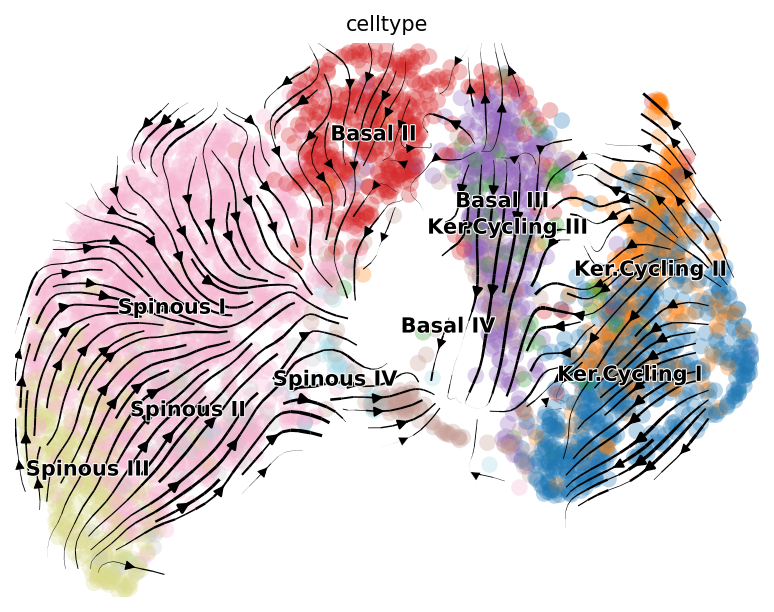

In [5]:
adata_dyn.obsm["X_umap"] = adata_dyn.obsm["X_umap.harmony"].copy()
scv.pl.velocity_embedding_stream(
    adata_dyn,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

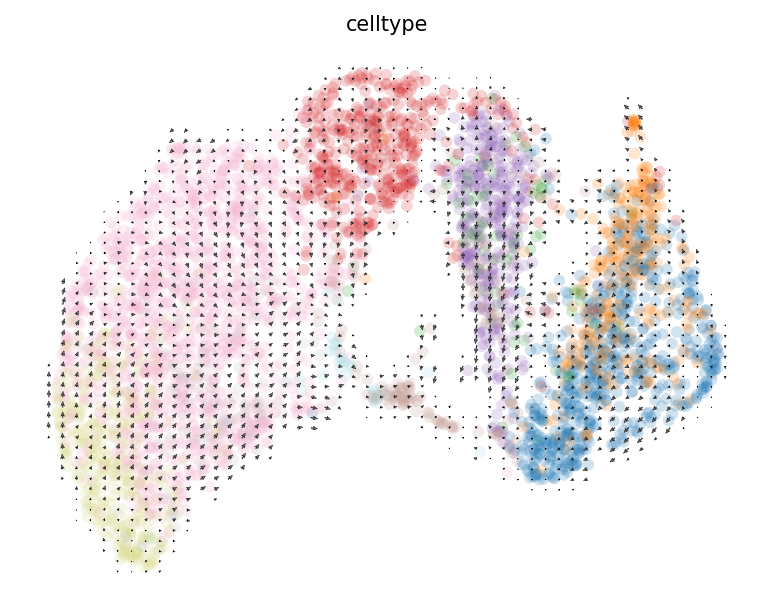

In [6]:
adata_dyn.obsm["X_umap"] = adata_dyn.obsm["X_umap.harmony"].copy()
scv.pl.velocity_embedding_grid(
    adata_dyn,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

## RUNNING STOCHASTIC

In [7]:
citeSEQ_Keratinocytes_IFE.scVeloPreprocess(n_pcs=20)
citeSEQ_Keratinocytes_IFE.computeVelocity(mode='s')

velocity_ker_ife = citeSEQ_Keratinocytes_IFE.getAdata()
adata_sto = velocity_ker_ife.copy()


Filtered out 73 genes that are detected 20 counts (spliced).
Logarithmized X.


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/16 cores)
    finished (0:00:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


NameError: name 'report_velocity' is not defined

In [15]:
citeSEQ_Keratinocytes_IFE.inspect()



=== Seurat-derived AnnData (adata) ===
Cells (obs): 3794
Genes (var): 12106
First 10 cell names: ['AAACGAAAGATTCGCT', 'AAACGAAAGCTCACTA', 'AAACGAAGTGTATCCA', 'AAACGAAGTTGCTCGG', 'AAACGAATCTCAACCC', 'AAACGCTCAAGAGATT', 'AAACGCTGTAGGTCAG', 'AAACGCTTCGCACTCT', 'AAAGAACCAACCGGAA', 'AAAGAACCATACAGAA']
First 10 gene names: ['Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Npbwr1', 'Rb1cc1', 'Pcmtd1', 'Rrs1', 'Mybl1']

=== Loom Spliced/Unspliced Data (ldata) ===
Cells (obs): 3794
Genes (var): 29365
First 10 cell names: ['AAACGAAAGATTCGCT', 'AAACGAAAGCTCACTA', 'AAACGAAGTGTATCCA', 'AAACGAAGTTGCTCGG', 'AAACGAATCTCAACCC', 'AAACGCTCAAGAGATT', 'AAACGCTGTAGGTCAG', 'AAACGCTTCGCACTCT', 'AAAGAACCAACCGGAA', 'AAAGAACCATACAGAA']
First 10 gene names: ['Xkr4', 'Gm19938', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Npbwr1', '4732440D04Rik']

Layer Shapes in ldata
spliced: (3794, 29365)
unspliced: (3794, 29365)
ambiguous: (3794, 29365)


In [ ]:
df = pd.DataFrame([dyn_report, sto_report])

cols = [
    "mode",
    "stored_n", "finite_n", "nan_n", "inf_n",
    "zero_n(stored)", "neg_n(stored)", "pos_n(stored)",
    "finite_frac", "nan_frac", "inf_frac",
    "zero_frac(stored, finite)", "neg_frac(stored, finite)", "pos_frac(stored, finite)",
    "cells_n", "zero_vel_cells_n", "zero_vel_cells_frac",
    "near_zero_vel_cells_n", "near_zero_vel_cells_frac",
    "vel_norm_median", "vel_norm_mean", "vel_norm_p95", "vel_norm_max",
]
df[cols]


,mode,stored_n,finite_n,nan_n,inf_n,zero_n(stored),neg_n(stored),pos_n(stored),finite_frac,nan_frac,...,"pos_frac(stored, finite)",cells_n,zero_vel_cells_n,zero_vel_cells_frac,near_zero_vel_cells_n,near_zero_vel_cells_frac,vel_norm_median,vel_norm_mean,vel_norm_p95,vel_norm_max
0,dynamical,45653202,1897000,43756202,0,54020,1083866,759114,0.041552,0.958448,...,0.400166,3794,0,0.0,0,0.0,NaN,NaN,NaN,NaN
1,stochastic,45653202,45653202,0,0,11631568,15956798,18064836,1.000000,0.000000,...,0.395697,3794,0,0.0,0,0.0,57.567253,58.760708,79.126042,104.34687


In [10]:
import scipy.sparse as sp

# choose current
curr = velocity_ker_ife.layers["Ms"] if "Ms" in velocity_ker_ife.layers else (
       velocity_ker_ife.layers["spliced"] if "spliced" in velocity_ker_ife.layers else velocity_ker_ife.X)

V = velocity_ker_ife.layers["velocity"]
proj = curr + V


In [11]:
import numpy as np
from scipy.io import mmwrite
import scipy.sparse as sp

if not sp.issparse(curr): curr = sp.csr_matrix(curr)
if not sp.issparse(proj): proj = sp.csr_matrix(proj)

mmwrite("curr.mtx", curr)
mmwrite("proj.mtx", proj)

np.savetxt("cells.txt", velocity_ker_ife.obs_names.to_numpy(), fmt="%s")
np.savetxt("genes.txt", velocity_ker_ife.var_names.to_numpy(), fmt="%s")

# optional: cluster labels / metadata for coloring later
velocity_ker_ife.obs.to_csv("obs.csv")


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

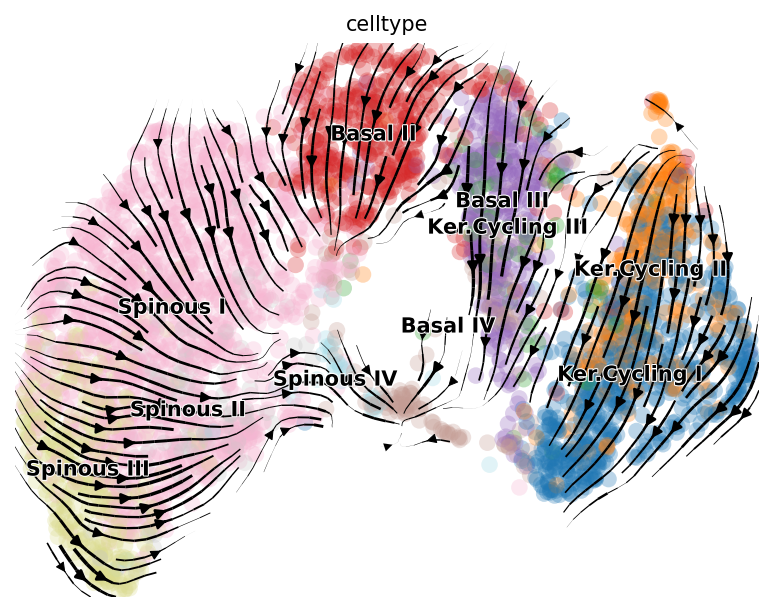

In [8]:
velocity_ker_ife = citeSEQ_Keratinocytes_IFE.getAdata()
velocity_ker_ife.obsm["X_umap"] = velocity_ker_ife.obsm["X_umap.harmony"].copy()
scv.pl.velocity_embedding_stream(
    velocity_ker_ife,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

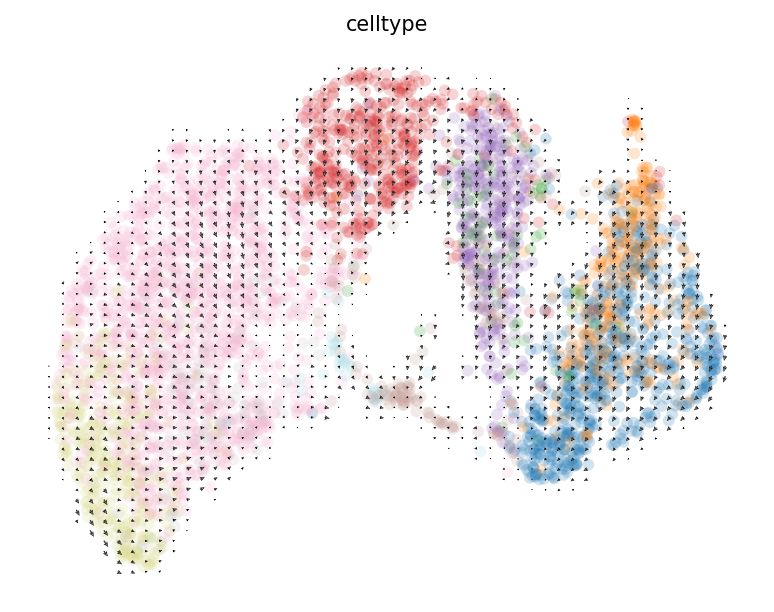

In [9]:
scv.pl.velocity_embedding_grid(
    velocity_ker_ife,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

## Open using IFE Ker VeloViz object!!!

In [12]:
h5ad_path = "/Users/marissaesteban/Desktop/marissasavethislater/UW_IFE_veloViz.h5ad"
loom_paths = ["/Volumes/PortableSSD/SRSP/CITEseq_looms/YS001/possorted_genome_bam_KLWV0.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS002/possorted_genome_bam_PNEM4.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS003/possorted_genome_bam_8Q2XV.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS004/possorted_genome_bam_0XB2N.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS005/possorted_genome_bam_HX08G.loom",
              "/Volumes/PortableSSD/SRSP/CITEseq_looms/YS006/possorted_genome_bam_751VB.loom"]

ife_veloviz_obj = VelocityObject(h5ad_path, loom_paths)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/loompy/utils.py:11: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"╭── " + message)
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/loompy/utils.py:12: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"╰──> at {frameinfo[2].filename}, line {frameinfo[2].lineno}")
INFO:biothings.client:querying 1-248 ...



==== Converting ENSEMBL Genes ====
Total ldata genes: 33696
ENSEMBL-like genes: 248
Already-symbol-like genes: 33448 



INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


Mapped ENSMUSG → symbol: 203
Unmapped ENSMUSG: 45
Total ENSMUSG IDs after mapping:  45

=== Removing duplicates ===
adata
Cells (original): 3772
Genes (original): 30481
Duplicate cell barcodes: 0
Duplicate genes: 0
ldata
Cells (original): 45487
Genes (original): 33696
Duplicate cell barcodes: 235
Duplicate genes: 27

 adata after dedup: (3772, 30481)
ldata after dedup: (45252, 33696)

=== Subsetting cells by GENES and BARCODES ===
Overlapping Cells: 3772
Overlapping genes: 29365

adata shape: (3772, 29365)
ldata shape: (3772, 29365)
Cells match: True
Genes match: True

Layers in adata_subset: ['spliced', 'unspliced', 'ambiguous']
Spliced shape: (3772, 29365)
Unspliced shape: (3772, 29365)

=== Seurat-derived AnnData (adata) ===
Cells (obs): 3772
Genes (var): 29365
First 10 cell names: ['AAACGAAAGATTCGCT', 'AAACGAAAGCTCACTA', 'AAACGAAGTGTATCCA', 'AAACGAAGTTGCTCGG', 'AAACGAATCTCAACCC', 'AAACGCTCAAGAGATT', 'AAACGCTGTAGGTCAG', 'AAACGCTTCGCACTCT', 'AAAGAACCAACCGGAA', 'AAAGAACCATACAGAA']
Fir

In [13]:
ife_veloviz_obj.scVeloPreprocess(n_pcs=20)
ife_veloviz_obj.computeVelocity(mode='s')

ife_veloviz_adata = ife_veloviz_obj.getAdata()

Filtered out 17259 genes that are detected 20 counts (spliced).
Normalized count data: spliced, unspliced.
Logarithmized X.


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/16 cores)
    finished (0:01:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

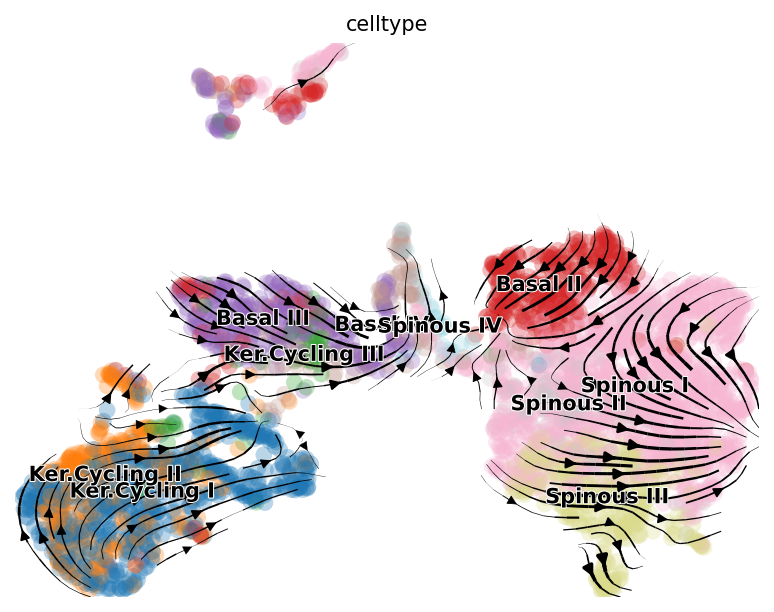

In [14]:

ife_veloviz_adata.obsm["X_umap"] = ife_veloviz_adata.obsm["X_vv_umap"].copy()
scv.pl.velocity_embedding_stream(
    ife_veloviz_adata,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

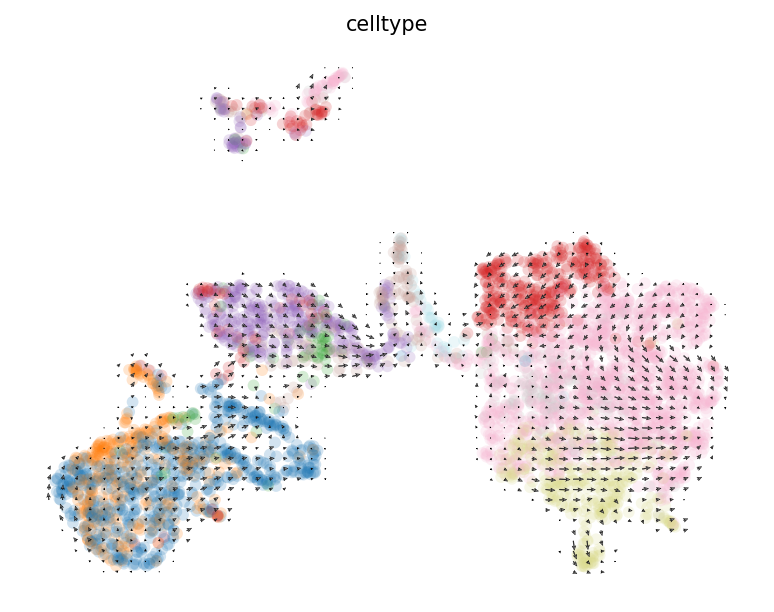

In [15]:
scv.pl.velocity_embedding_grid(
    ife_veloviz_adata,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

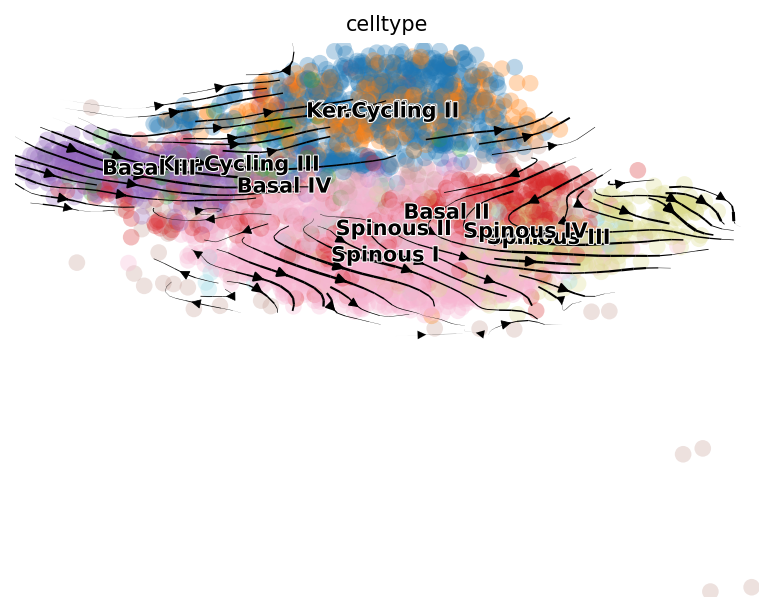

In [16]:
ife_veloviz_adata.obsm["X_umap"] = ife_veloviz_adata.obsm["X_veloviz"].copy()
scv.pl.velocity_embedding_stream(
    ife_veloviz_adata,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)

/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo_env/lib/python3.10/site-packages/scvelo

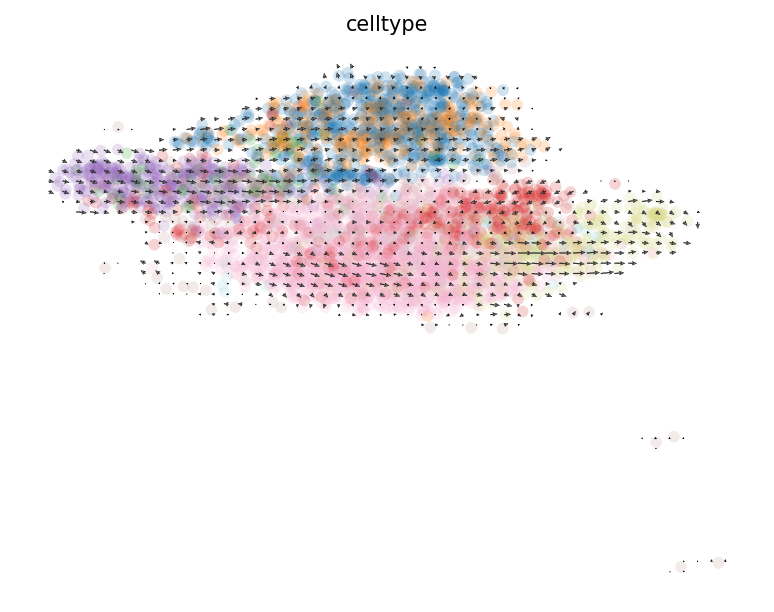

In [17]:
ife_veloviz_adata.obsm["X_umap"] = ife_veloviz_adata.obsm["X_veloviz"].copy()
scv.pl.velocity_embedding_grid(
    ife_veloviz_adata,
    basis='X_umap',     
    color='celltype',
    palette="tab20",
    dpi=150
)